# Introduction to the Low-salt-rejection Reverse Osmosis (LSRRO) Flowsheet
This tutorial shows how to build, initialize, simulate, and optimize an LSRRO flowsheet using WaterTAP.

![alt text](../docs/_static/flowsheets/lsrro.png)

## High-level Preview: Run an LSRRO optimization case.
#### 3-stage system
#### 70 g/L TDS feed, 50% Recovery


In [1]:
from watertap.flowsheets.lsrro.lsrro import (
    ACase,
    BCase,
    ABTradeoff,
    run_lsrro_case,
)
import logging
logging.getLogger("idaes").setLevel(logging.ERROR)
logging.getLogger("pyomo").setLevel(logging.ERROR)

In [2]:
# %%capture 
m, results = run_lsrro_case(
    number_of_stages=3,
    water_recovery=0.50,
    Cin=70,  # inlet NaCl conc kg/m3,
    Qin=1e-3,  # inlet feed flowrate m3/s
    A_case=ACase.optimize,
    B_case=BCase.optimize,
    AB_tradeoff=ABTradeoff.equality_constraint,
    has_NaCl_solubility_limit=True,
    has_calculated_concentration_polarization=True,
    has_calculated_ro_pressure_drop=True,
    permeate_quality_limit=1000e-6,
    AB_gamma_factor=1,
    # B_max=3.5e-6,
    number_of_RO_finite_elements=10,
    skip_initialization=True
)


Feed Concentration = 70.0 ppt

***---Simulation results---***
Simulation failed. The current configuration is infeasible. Please adjust the decision variables.

***---Optimization results---***
----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1000 ppm
Brine: 0.548 kg/s, 126890 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 265.86
Energy Consumption: 7.6 kWh/m3
Levelized cost of water: 1.71 $/m3
Primary Pump Capital Cost ($/m3):0.5047265838517884
Booster Pump Capital Cost ($/m3): 0.1318504520423668
ERD Capital Cost ($/m3):0.04116999386381928
Membrane Capital Cost ($/m3): 0.14321735175018716
Indirect Capital Cost ($/m3): 0.4104821907540809
Electricity cost ($/m3): 0.5323462487411282


--decision variables--
Stage 1 operating pressure 85.0 bar
Stage 1 membrane area      156.2 m2
Stage 1 water perm. coeff.  1.5 LMH/bar
Stage 1 salt perm. coeff.  0.1 LMH
Stage 2 operating pressure 65.0 bar
Stage 2 membrane area      97.3 m2
Stage 2 water 

## Overview of setting up and optimizing the LSRRO flowsheet--step by step.
* Step 0: Import Python libraries.
* Step 1: Build the LSRRO flowsheet.
* Step 2: Set specifications for LSRRO flowsheet.
* Step 3: Initialize the LSRRO flowsheet.
* Step 4: Optimize the LSRRO flowsheet.
* Step 5: Visualize results.

## Step 0: Import libraries.

In [3]:
# Import LSRRO flowsheet module
from watertap.flowsheets.lsrro import lsrro

## Step 1: Build the LSRRO flowsheet.

In [4]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = lsrro.build(
    number_of_stages=3,
    has_NaCl_solubility_limit=True,
    has_calculated_concentration_polarization=True,
    has_calculated_ro_pressure_drop=True,
    number_of_RO_finite_elements=10,

)


## Step 2: Set specifications for the LSRRO flowsheet.

In [5]:
lsrro.set_operating_conditions(m)

Feed Concentration = 70.0 ppt


## Step 3: Initialize the LSRRO flowsheet model.

In [6]:
lsrro.initialize(m)

--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
INFO: Starting Sequential Decomposition
INFO: Starting first pass run of network
2025-09-03 15:38:04 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-09-03 15:38:05 [INFO] idaes.init.fs.PrimaryPumps[1].control_volume: Initialization Complete
2025-09-03 15:38:05 [INFO] idaes.init.fs.PrimaryPumps[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-03 15:38:06 [INFO] idaes.init.fs.Mixers[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-03 15:38:07 [INFO] idaes.init.fs.ROUnits[1].feed_side: Initialization Complete
2025-09-03 15:38:13 [INFO] idaes.init.fs.ROUnits[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-03 15:38:14 [INFO] idaes.init.fs.EnergyRecoveryDevices[1].control_volume: Initialization Comple

## Step 4: Simulate the LSRRO flowsheet.

In [7]:
lsrro.solve(m)


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2039, 'Number of variables': 2039, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.25714731216430664}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [8]:
m.fs.feed.properties.display()

Block fs.feed.properties[0.0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key             : Lower : Value               : Upper : Fixed : Stale : Domain
         ('Liq', 'H2O') :   0.0 :  0.9756115306213978 :  None :  True :  True : NonNegativeReals
        ('Liq', 'NaCl') :   0.0 : 0.06999999999987827 :  None :  True :  True : NonNegativeReals
    temperature : State temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value  : Upper  : Fixed : Stale : Domain
        None : 273.15 : 293.15 : 373.15 :  True :  True : NonNegativeReals
    pressure : State pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower   : Value  : Upper      : Fixed : Stale : Domain
        None : 10000.0 : 101325 : 50000000.0 :  True :  True : NonNegativeReals
    flow_vol_phase : Volumetric flow rate
        Size=1, Index=fs.properties.phase_list, Units=m**3/s
        Key :

In [9]:
print("Simulation Results:\n")
lsrro.display_system(m)

Simulation Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.349 kg/s, 751 ppm
Brine: 0.697 kg/s, 100084 ppm
Volumetric water recovery: 35.0%
Number of Stages: 3
Total Membrane Area: 183.33
Energy Consumption: 10.4 kWh/m3
Levelized cost of water: 2.41 $/m3
Primary Pump Capital Cost ($/m3):0.8290266209380903
Booster Pump Capital Cost ($/m3): 0.16734617929012008
ERD Capital Cost ($/m3):0.06539992139610248
Membrane Capital Cost ($/m3): 0.14403584004108508
Indirect Capital Cost ($/m3): 0.6029042808326991
Electricity cost ($/m3): 0.7309236776200411




## Step 5: Optimize the LSRRO flowsheet.

In [10]:
lsrro.optimize_set_up(m,
    water_recovery=0.5,
    A_case=ACase.optimize,
   B_case=BCase.optimize,
    AB_tradeoff=ABTradeoff.equality_constraint,
    permeate_quality_limit=500e-6,
    )
optimization_results = lsrro.solve(m, raise_on_failure=True) 

In [11]:
print("Optimization Results:\n")
lsrro.display_system(m)

Optimization Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 500 ppm
Brine: 0.548 kg/s, 127301 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 242.69
Energy Consumption: 9.0 kWh/m3
Levelized cost of water: 1.94 $/m3
Primary Pump Capital Cost ($/m3):0.5508102736918976
Booster Pump Capital Cost ($/m3): 0.18165719719739787
ERD Capital Cost ($/m3):0.04458632368629701
Membrane Capital Cost ($/m3): 0.1469527167064308
Indirect Capital Cost ($/m3): 0.46200325564101163
Electricity cost ($/m3): 0.6276017013441124




## 

## Step 6: Visualize results

In [12]:
from watertap.flowsheets.lsrro.multi_sweep import _lsrro_presweep as setup_sensitivity_sweep
from parameter_sweep import LinearSample, parameter_sweep
number_of_stages = 3
output_filename = f"param_sweep_output/{number_of_stages}_stage/results_LSRRO.csv"
sweep_params = {}
outputs = {}
nx = 3

# m = setup_sensitivity_sweep(number_of_stages=number_of_stages)
m.fs.feed.flow_mass_phase_comp.unfix()
m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"].fix()
m.fs.feed.properties[0].flow_vol_phase["Liq"].fix()
# Sweep parameters ------------------------------------------------------------------------

sweep_params["Feed Concentration"] = LinearSample(m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"], 70, 150, nx)

sweep_params["Volumetric Recovery Rate"] = LinearSample(m.fs.water_recovery, 0.2, 0.65, nx)

# Outputs  -------------------------------------------------------------------------------
outputs["LCOW"] = m.fs.costing.LCOW
outputs["LCOW wrt Feed Flow"] = m.fs.costing.LCOW_feed
outputs["SEC"] = m.fs.costing.specific_energy_consumption
outputs["SEC wrt Feed"] = m.fs.costing.specific_energy_consumption_feed

sweep_sensitivity_results = parameter_sweep(
        m,
        sweep_params,
        outputs,
        csv_results_file_name=output_filename,
        optimize_function=lsrro.solve,
        interpolate_nan_outputs=True,
    )

In [13]:
import pandas as pd

results= pd.read_csv(output_filename)
results

,# Feed Concentration,Volumetric Recovery Rate,LCOW,LCOW wrt Feed Flow,SEC,SEC wrt Feed
0,70.0,0.200,2.498389,0.499678,10.394270,2.078854
1,70.0,0.425,1.866045,0.793069,8.290743,3.523566
2,70.0,0.650,2.964402,1.926861,13.527990,8.793193
3,110.0,0.200,6.798038,1.359608,28.273460,5.654692
4,110.0,0.425,6.174104,2.623994,26.831940,11.403580
5,110.0,0.650,NaN,NaN,NaN,NaN
6,150.0,0.200,16.765130,3.353026,70.737140,14.147430
7,150.0,0.425,NaN,NaN,NaN,NaN
8,150.0,0.650,NaN,NaN,NaN,NaN


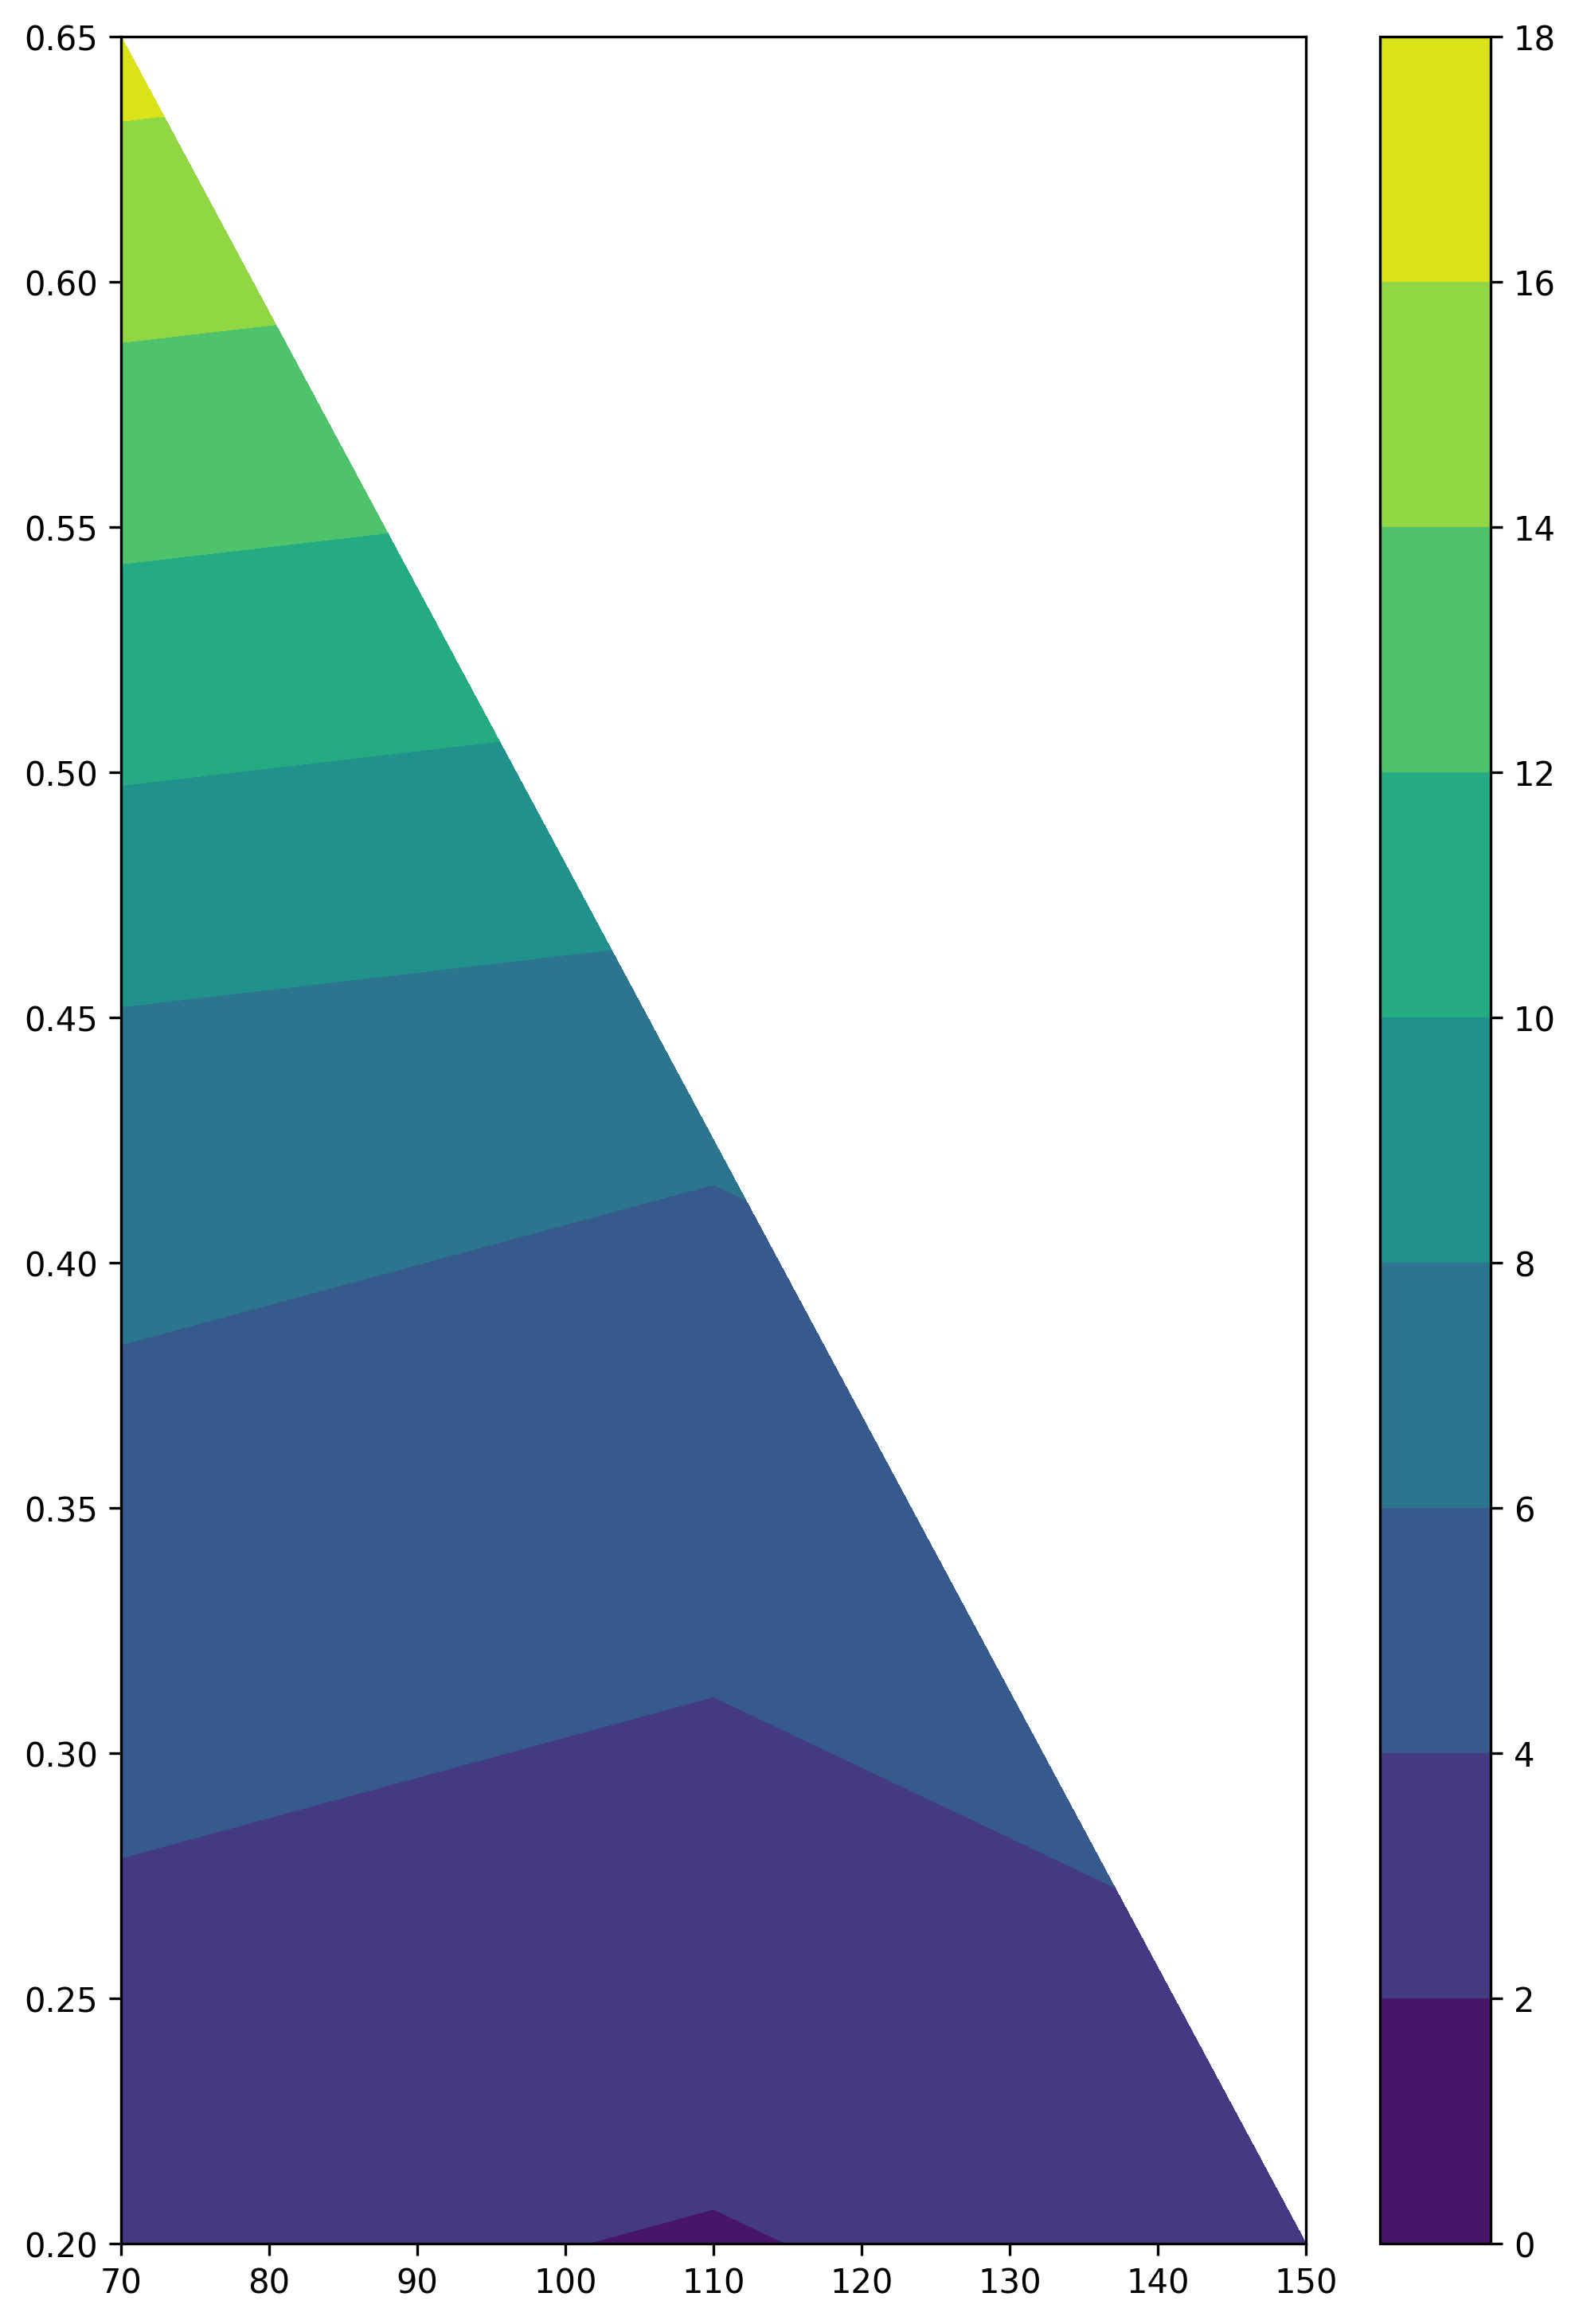

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1,1, figsize=(8, 12), dpi=300)

X, Y = np.meshgrid(np.unique(results["# Feed Concentration"].to_numpy()), np.unique(results["Volumetric Recovery Rate"].to_numpy()))

Z = results["LCOW"].to_numpy().reshape(X.shape)

cbar = ax.contourf(X,Y,Z)
                        #   colors=ylgnbu(np.linspace(0, 1, len(contf_levels))), extend='max')

cbar = fig.colorbar(cbar, ax=ax)